In [ ]:
%pip install numpy
%pip install matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import warnings


Helper function for visualisations

In [ ]:
def plot(x, y, title=None):
    plt.figure(figsize=(4, 3))
    plt.scatter(x, y, color='red', s=3) 
    plt.xlabel("X values")
    plt.ylabel("Y values")
    if title:
        plt.title(title)
    else:
        plt.title("Scatterplot Comparison")
    plt.grid(True)
    plt.show()

def plot_comparison(values1, values2, title=None):
    plt.figure(figsize=(4, 3))
    plt.scatter(values1[0], values1[1], color='red', label='Actual Values', s=3) 
    plt.scatter(values2[0], values2[1], color='blue', label='Predicted Values',s =3) 
    plt.xlabel("X values")
    plt.ylabel("Y values")
    if title:
        plt.title(title)
    else:
        plt.title("Scatterplot Comparison")
    plt.grid(True)
    plt.legend()
    plt.show()

Generating and pre-preparing the datasets

In [ ]:
def generate_polynomial_dataset(degree, n_samples):
    X = np.random.uniform(-5, 5, n_samples).reshape(-1, 1)
    y = []
    for xi in X:
        sum = 0
        for ki in range(degree + 1):
            ak = np.random.uniform(0, 1)
            term = ak * (xi ** ki)
            sum += term
        e = np.random.normal(0, 1)
        yi = sum + e
        y.append(yi)
    return X, y

In [ ]:
X_linear, y_linear = generate_polynomial_dataset(1, 1000)
X_quad, y_quad = generate_polynomial_dataset(2, 1000)
X_cubic, y_cubic = generate_polynomial_dataset(3, 1000)

plot(X_linear, y_linear, "Linear Dataset")
plot(X_quad, y_quad, "Quadratic Dataset")
plot(X_cubic, y_cubic, "Cubic Dataset")

X_quad = np.hstack((X_quad, X_quad**2))
X_quad = StandardScaler().fit_transform(X_quad)
X_cubic = np.hstack((X_cubic, X_cubic**2, X_cubic**3))
X_cubic = StandardScaler().fit_transform(X_cubic)

X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.2)
X_quad_train, X_quad_test, y_quad_train, y_quad_test = train_test_split(X_quad, y_quad, test_size=0.2)
X_cubic_train, X_cubic_test, y_cubic_train, y_cubic_test = train_test_split(X_cubic, y_cubic, test_size=0.2)

In [ ]:
alpha_choices = [0, 0.1, 100]

Closed Form Ridge Regression

In [ ]:
class RidgeRegression_ClosedForm():
    def __init__(self, alpha = 0.5):
        self.alpha = alpha
        self.weights = None

    def train(self, X, y):
        X = np.insert(X, X.shape[1], 1, axis=1)
        biased_i = np.identity(len(X[0]))
        biased_i[0,0] = 0
        XT = np.transpose(X)
        self.weights = np.linalg.inv((XT @ X) + self.alpha * biased_i) @ XT @ y

    def predict(self, X):
        X = np.insert(X, X.shape[1], 1, axis=1)
        return X @ self.weights

In [ ]:
for alpha in alpha_choices:
    linear_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    linear_reg_cf.train(X_linear_train, y_linear_train)
    y_linear_predicted = linear_reg_cf.predict(X_linear_test)
    plot_comparison([X_linear_test, y_linear_test], [X_linear_test, y_linear_predicted], f'Linear Comparison alpha = {alpha}')

In [ ]:
for alpha in alpha_choices:
    quad_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    quad_reg_cf.train(X_quad_train, y_quad_train)
    y_quad_predicted = quad_reg_cf.predict(X_quad_test)
    plot_comparison([X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], y_quad_predicted], f'Quadratic Comparison alpha = {alpha}')

In [ ]:
for alpha in alpha_choices:
    cubic_reg_cf = RidgeRegression_ClosedForm(alpha = alpha)
    cubic_reg_cf.train(X_cubic_train, y_cubic_train)
    y_cubic_predicted = cubic_reg_cf.predict(X_cubic_test)
    plot_comparison([X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], y_cubic_predicted], f'Cubic Comparison alpha = {alpha}')

Scikit learn SGD regression

In [ ]:
MAX_ITERATIONS = 1000
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

def predict_SGDReg(X, Y, X_test, alpha):
    sgd_reg = SGDRegressor(penalty='l2', alpha=alpha, max_iter=MAX_ITERATIONS)
    sgd_reg.fit(X, Y)
    return sgd_reg.predict(X_test)

In [ ]:
for alpha in alpha_choices:
    y_linear_predicted = predict_SGDReg(X_linear_train, y_linear_train, X_linear_test, alpha)
    plot_comparison([X_linear_test, y_linear_test], [X_linear_test, y_linear_predicted], f'Linear Comparison: alpha = {alpha}')

In [ ]:
for alpha in alpha_choices:
    y_quad_predicted = predict_SGDReg(X_quad_train, y_quad_train, X_quad_test, alpha)
    plot_comparison([X_quad_test[:,0], y_quad_test], [X_quad_test[:,0], y_quad_predicted], f'Quadratic Comparison: alpha = {alpha}')


In [ ]:
for alpha in alpha_choices:
    y_cubic_predicted = predict_SGDReg(X_cubic_train, y_cubic_train, X_cubic_test, alpha)
    plot_comparison([X_cubic_test[:,0], y_cubic_test], [X_cubic_test[:,0], y_cubic_predicted], f'Cubic Comparison: alpha = {alpha}')
    

COLUMNS:
0 = ID: Can be discarded
1 = y array (classifications)
2-11 = Mean values of radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimensions
12-21 = Standard error of values of same 10 fields
22-31 = Worst value of same 10 fields


In [214]:
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


In [ ]:
def visualise_features(mean, se, worst, features):
    fig, axes = plt.subplots(10, 1, figsize=(6, 30))

    for i in range(10):
        sns.histplot(mean.iloc[:, i], ax=axes[i], color='blue', label='Mean')
        sns.histplot(se.iloc[:, i], ax=axes[i], color='red', label='SE')
        sns.histplot(worst.iloc[:, i], ax=axes[i], color='green', label='Worst')
        
        axes[i].set_title(f'Distribution of {features[i]} ')
        axes[i].set_xlabel(f'{features[i]}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
FEATURES = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimensions"]

data = pd.read_csv('data/wdbc.data', header=None)

headings = ['id', 'diagnosis']
for feature_type in ['mean','se','worst']:
    for feature in FEATURES:
        headings.append(feature_type + '_' + feature)

data.columns = headings

data.drop(columns=['id'], inplace=True)

mean_df = data.iloc[:, 1:11]
se_df = data.iloc[:, 11:21]
worst_df = data.iloc[:, 21:31]
print(data.)
visualise_features(mean_df, se_df, worst_df, FEATURES)

In [243]:
mean = mean_df.values
se = se_df.values
worst = worst_df.values

X = mean + se
X = StandardScaler().fit_transform(X)
y = data.iloc[:, 0].values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2) #STRATIFY?

parameter_grid = {
    'C': [0.5, 1.0, 3.0, 10.0], # C parameter (regularisation)
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernel types
    'class_weight': ['balanced', None] # whether classes should be weighted inversely proporitional to frequency or treated equally
}

svc = SVC()
strat_cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(svc, parameter_grid, cv=strat_cv, scoring='accuracy')
grid_search.fit(train_X, train_y)
optimal_model = grid_search.best_estimator_

print(grid_search.best_params_)



{'C': 3.0, 'class_weight': None, 'kernel': 'rbf'}


(a) Do you need to stratify your cross-validation? - yes
(b) What scoring metric is most appropriate for this task? 
(c) What hyperparameters did you choose? How many models did you fit in total? 
(d) Present your results for the optimal hyperparameter combination.


ACCURACY: 0.9473684210526315


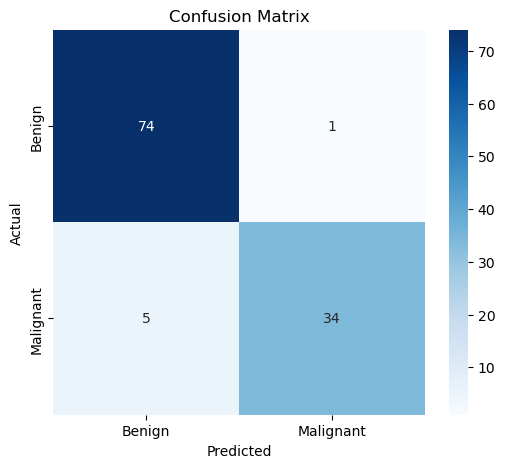

In [244]:
score = optimal_model.score(test_X,test_y)
print(f'ACCURACY: {score}')

predicted_y = optimal_model.predict(test_X)

confusion = confusion_matrix(test_y, predicted_y)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()